저희는 라벨이 없는 데이터를 학습하기 위해 
1. AE(Auto Encoder)
2. VAE(Variational Auto Encoder)
3. OCSVM(One Class SVM)
4. IsoForest
5. Elliptic Envelope
6. USAD(Unsupervised Anomaly Detection) - AE + GAN
을 리뷰하고 학습시킨 뒤 성능이 가장 좋은 모델 3개를 앙상블하여 과반수가 사기 거래라고 탐지한 경우를 재조정하여 성능을 끌어올렸습니다.
USAD의 경우 AE와 GAN의 장점을 활용하여 모델을 설계했는데 저희 데이터에 적용했을 때 성능이 잘 나와서 최종 모델로 선정했습니다.

# Colab Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("./drive/MyDrive/데이콘/데이터/신용카드")

In [ ]:
import os
PATH = "Your Data Path"
os.chdir(PATH)

# Import

In [7]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import Normalizer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import wandb
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.utils.data as data_utils

# Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

# Load Dataset & EDA
--> ABS Amount와 Amount 컬럼을 그래프로 그렸을 때 정상 거래와 사기 거래 분포의 차이가 심해 새로운 피쳐로 활용

In [4]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.drop(columns=['ID'])
train_df["ABS Amount"] = train_df.abs().sum(1)
train_df["Amount"] = train_df.sum(1)
val_df = pd.read_csv('./val.csv')
val_df = val_df.drop(columns=['ID'])
val_df["ABS Amount"] = val_df.abs().sum(1)
val_df["Amount"] = val_df.sum(1)
test_df = pd.read_csv('./test.csv')
test_df = test_df.drop(columns=['ID'])
test_df["ABS Amount"] = test_df.abs().sum(1)
test_df["Amount"] = test_df.sum(1)

## Scaler : Normalizer


In [5]:
scaler = Normalizer()
train = scaler.fit_transform(train_df)
train = pd.DataFrame(train, columns = train_df.columns)
val = scaler.transform(val_df.drop(columns = ["Class"]))
val = pd.DataFrame(val, columns = [col for col in val_df.columns if col != "Class"])
val["Class"] = val_df["Class"]
test = scaler.transform(test_df)
test = pd.DataFrame(test, columns = test_df.columns)

## Visualization
* 초록색 : Label이 없는 Train Data
* 파란색 : 정상 거래 Validation Data
* 주황색 : 사기 거래 Validation Data


--> 사기 거래의 경우 ABS Amount, Amount Column의 분포가 정상 거래와 차이가 심한 것을 알 수 있음

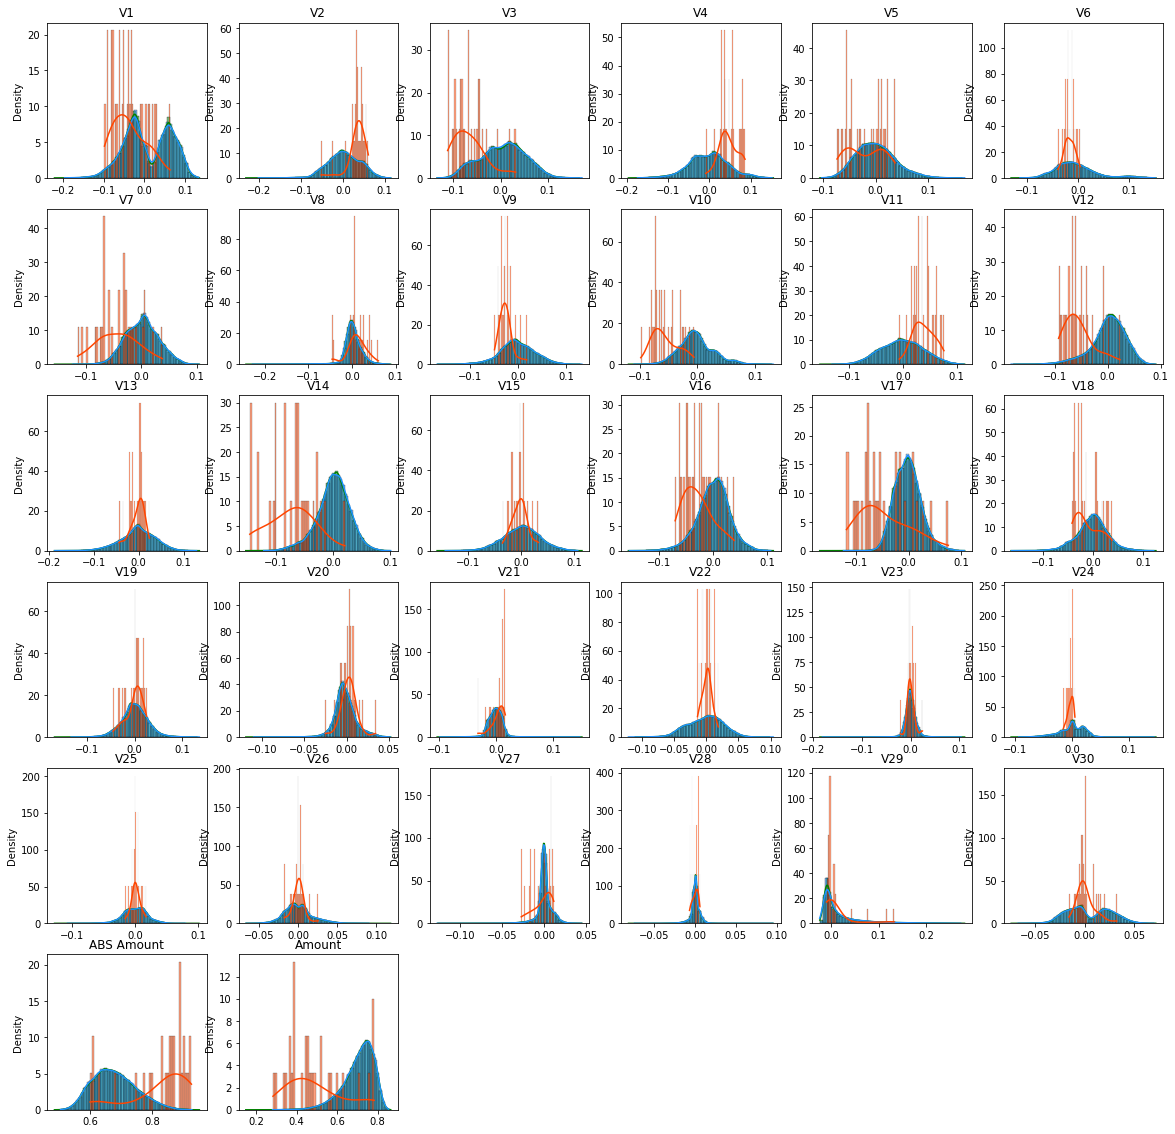

In [8]:
inliers = val[val['Class']==0]
outliers = val[val['Class']==1]
columns = val.drop('Class', axis=1).columns

grid = gridspec.GridSpec(6, 6)
plt.figure(figsize=(20, 20))

for n, col in enumerate(val_df[columns]):
    ax = plt.subplot(grid[n])
    sns.histplot(train[col], bins=50, color='green', stat='density', kde=True)
    sns.histplot(inliers[col], bins=50, color='dodgerblue', stat='density', kde=True)
    sns.histplot(outliers[col], bins=50, color='orangered', stat='density', kde=True)
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

# Train
* USAD 활용(Auto Encoder + GAN)
* 학습이 쉬운 오토인코더를 Adversarial Training에 적용하여 사기 거래의 디테일한 정보를 모델이 학습하도록 유도
## USAD 
* 2개의 오토인코더가 각각 Generator, Discriminator 역할을 수행
* 1개의 오토인코더는 최대한 진짜 같은 가짜를 만들고(Generator), 다른 1개는 가짜 데이터(=Generator를 통해 만들어진 데이터)가 입력되었을 때 Loss가 커지도록 설계해 진짜 데이터(=원본 데이터)와 가짜 데이터의 디테일한 차이를 학습하도록 유도

![USAD](https://user-images.githubusercontent.com/52459996/184940776-3b08c2a6-ee79-4b89-947a-f7610c2f6a5e.jpg)
<br>*USAD Architecture*

### Architecture
* 각각의 오토인코더의 경우 히든 노드의 수가 인풋, 아웃풋 노드의 수보다 크게 설계

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, z_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 128)
    self.linear2 = nn.Linear(128, 512)
    self.linear3 = nn.Linear(512, z_size)
    self.relu = nn.ReLU(True)
        
  def forward(self, real):
    out = self.linear1(real)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z
    
class Decoder(nn.Module):
  def __init__(self, z_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(z_size, 512)
    self.linear2 = nn.Linear(512, 128)
    self.linear3 = nn.Linear(128, output_size)
    self.relu = nn.ReLU(True)
        
  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    return out
    
class UsadModel(nn.Module):
  def __init__(self, input_size, z_size):
    super().__init__()
    self.encoder = Encoder(input_size, z_size)
    self.decoder1 = Decoder(z_size, input_size)
    self.decoder2 = Decoder(z_size, input_size)
  
  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
            wandb.log({"AE1 Loss":loss1,
                       "AE2 Loss":loss2})  
        print(f"Epoch : {epoch+1}, Train Loss : AE1 = {loss1}, AE2 = {loss2}")
        f1_score, threshold = calc_f1(model, val_loader)
        torch.save(model.state_dict(), './usad_normal.pth', _use_new_zipfile_serialization=False)
    return  threshold


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

### Performance Metric
* 신용카드 대회에서 활용하는 평가 지표인 Macro F1 Score 활용
* 정상 거래와 사기 거래를 구분하는 임계값을 Validation Data를 통해 결정(검증 데이터와 테스트 데이터 분포가 동일하다고 가정)
* 0부터 100까지 0.1 단위로 나눈 실수 값 중에서 제일 높은 Macro F1 Score를 만드는 Threshold 정보를 가져온다(제출할 때 활용)

In [ ]:
def calc_f1(model, val_loader):
    model.eval()
    pred = []
    true = []
    diffs = []
    with torch.no_grad():
        for x, y in iter(val_loader):
            x = x.float().to(device)

            _x = model.decoder1(model.encoder(x))
            l1loss = nn.L1Loss(reduction = "none")
            diff = l1loss(x, _x)
            diff = torch.sum(diff, 1).cpu().numpy().tolist()
            diffs.extend(diff)

            # f1 score
            true += y.tolist()
    thresholds = []
    f1_scores = []
    for thr in np.linspace(0,100, 1000):
      thresholds.append(thr)
      pred = np.where(np.array(diffs)>thr, 1,0).tolist()
      f1_scores.append(f1_score(true, pred, average='macro'))

    max_f1 = max(f1_scores)
    threshold = thresholds[np.argmax(f1_scores)]
    wandb.log({"confusion matrix" : wandb.plot.confusion_matrix(probs=None,
                          y_true=true, preds=np.where(np.array(diffs)>threshold, 1,0).tolist(),
                          class_names=["Normal","Abnormal"])})       

    diffs = [[d] for d in diffs]
    table = wandb.Table(data=diffs, columns=["MAE"])
    wandb.log({"MAE Distribution":wandb.plot.histogram(table, "MAE", title=None),
                "Threshold":threshold,
                "F1 Score": max_f1})
    return max_f1, threshold

In [ ]:
device = get_default_device()
BATCH_SIZE =  256
N_EPOCHS = 100
input_size = 32
z_size = 1024

train_loader = torch.utils.data.DataLoader(
                                          data_utils.TensorDataset(torch.from_numpy(train.values).float()),
                                          batch_size=BATCH_SIZE,
                                          shuffle=True, 
                                          num_workers=6
                                          )

val_loader = torch.utils.data.DataLoader( 
                                          data_utils.TensorDataset(torch.from_numpy(val.drop(columns=["Class"]).values).float(), torch.from_numpy(val["Class"].values).float()), 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False, 
                                          num_workers=6
                                          )

test_loader = torch.utils.data.DataLoader(
                                          data_utils.TensorDataset(torch.from_numpy(test.values).float()),
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, 
                                          num_workers=6
                                          )

model = UsadModel(input_size, z_size)
model = to_device(model,device)

### Wandb
* Wandb Logging을 통해 Loss와 Macro F1 Score와 Confusion Matrix를 시각화

In [ ]:
wandb.init(project = "Credit Card - USAD")

wandb: Currently logged in as: mrlee. Use `wandb login --relogin` to force relogin


In [ ]:
threshold = training(N_EPOCHS,model,train_loader,val_loader)

Epoch : 1, Train Loss : AE1 = 0.0005837494973093271, AE2 = 0.0007318794960156083
Epoch : 2, Train Loss : AE1 = 0.0005016079521737993, AE2 = -3.587163519114256e-05
Epoch : 3, Train Loss : AE1 = 0.0008520272676832974, AE2 = -0.00047906776308082044
Epoch : 4, Train Loss : AE1 = 0.001365168602205813, AE2 = -0.0011336291208863258
Epoch : 5, Train Loss : AE1 = 0.001538492040708661, AE2 = -0.001402906607836485
Epoch : 6, Train Loss : AE1 = 0.0015255287289619446, AE2 = -0.0014344269875437021
Epoch : 7, Train Loss : AE1 = 0.0015762433176860213, AE2 = -0.0015181534690782428
Epoch : 8, Train Loss : AE1 = 0.0014791744761168957, AE2 = -0.0014374940656125546
Epoch : 9, Train Loss : AE1 = 0.0014621515292674303, AE2 = -0.0014330126577988267
Epoch : 10, Train Loss : AE1 = 0.001596221700310707, AE2 = -0.0015752870822325349
Epoch : 11, Train Loss : AE1 = 0.0014897430082783103, AE2 = -0.0014669930096715689
Epoch : 12, Train Loss : AE1 = 0.0014376842882484198, AE2 = -0.001292732427828014
Epoch : 13, Train 

KeyboardInterrupt: ignored

![Confusion Matrix](https://user-images.githubusercontent.com/52459996/184943772-bf91cf4d-f863-41a9-8352-c428b5fa20b7.jpg)
*Confusion Matrix : 대부분의 경우 잘 맞추는 것을 확인 가능*
![Logging](https://user-images.githubusercontent.com/52459996/184943789-1addf423-5f42-4941-b153-a86f7b447c0b.jpg)
*AE1 Loss, AE2 Loss, Macro F1 Score, Threshold Logging*

# Inference
* Threshold = 1.4 일 때 Macro F1 Score가 제일 높다

In [ ]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    diffs = []
    with torch.no_grad():
        for [x] in iter(test_loader):

            x = x.float().to(device)
            _x = model.decoder1(model.encoder(x))
            l1loss = nn.L1Loss(reduction = "none")
            diff = l1loss(x, _x)
            diff = torch.sum(diff, 1).cpu().numpy().tolist()
            diffs.extend(diff)

    pred = np.where(np.array(diffs)>thr, 1,0).tolist()
    return pred

In [ ]:
preds = prediction(model, 1.4, test_loader, device)

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = preds
submit.to_csv('./USAD Normal.csv', index=False)

# Ensemble
* Elliptic Envelope Model을 활용
* Wandb Sweep를 통해 성능이 제일 좋은 하이퍼파라미터 활용
* Elliptic Envelope Model 2개와 USAD 1개를 활용하여 3개 모델 중 2개 이상 사기 거래라 지목된 경우만 사기 거래라고 변경(Majority Voting)

![Grid](https://user-images.githubusercontent.com/52459996/185151588-4589fe9d-a14a-4804-aa53-a3346164585d.png)

In [ ]:
from sklearn.covariance import EllipticEnvelope

sweep_config = {
    "method": "grid", # try grid or random
    "metric": {
      "name": "F1 - Macro",
      "goal": "maximize"   
    },
    "parameters": {
        "support_fraction": {
            "values": [0.1,0.2, 0.3,0.4, 0.5,0.6, 0.7,0.8,0.9,0.95]
        },
        "contamination": {
            "values": [0.0001,0.0005,0.001,0.005]
        },
    }
}

def get_pred_label(model,x,y):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    
    model_pred = model.predict(x)
    

    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    
    score = f1_score(y, model_pred, average='macro')


    wandb.log({"confusion matrix" : wandb.plot.confusion_matrix(probs=None,
                          y_true=y, preds=model_pred,
                          class_names=["Normal","Abnormal"])})    
    wandb.log({"F1 - Macro": score})
    return model_pred

def elliptic(config=None):
  wandb.init(config=config)  # defaults are over-ridden during the sweep
  config = wandb.config
  train_df = pd.read_csv('./train.csv')
  train_df = train_df.drop(columns=['ID'])
  train_df["ABS Amount"] = train_df.abs().sum(1)
  train_df["Amount"] = train_df.sum(1)

  val_df = pd.read_csv('./val.csv')
  val_df = val_df.drop(columns=['ID'])
  val_df["ABS Amount"] = val_df.abs().sum(1)
  val_df["Amount"] = val_df.sum(1)

  scaler = Normalizer() 
  train = scaler.fit_transform(train_df)
  train = pd.DataFrame(train, columns = train_df.columns)
  val = scaler.transform(val_df.drop(columns = ["Class"]))
  val = pd.DataFrame(val, columns = [col for col in val_df.columns if col != "Class"])
  val["Class"] = val_df["Class"]
  model = EllipticEnvelope(support_fraction = config.support_fraction, contamination = config.contamination, random_state = 42)
  model.fit(train)
  get_pred_label(model, val.drop(columns=["Class"]),val["Class"])

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Credit Card - Elliptic")
wandb.agent(sweep_id, elliptic, count=40)

In [ ]:
train_df = pd.read_csv('./train.csv')
train_df = train_df.drop(columns=['ID'])
train_df["ABS Amount"] = train_df.abs().sum(1)
train_df["Amount"] = train_df.sum(1)

val_df = pd.read_csv('./val.csv')
val_df = val_df.drop(columns=['ID'])
val_df["ABS Amount"] = val_df.abs().sum(1)
val_df["Amount"] = val_df.sum(1)


test_df = pd.read_csv('./test.csv')
test_df = test_df.drop(columns=['ID'])



test_df["ABS Amount"] = test_df.abs().sum(1)
test_df["Amount"] = test_df.sum(1)

scaler = Normalizer() # RobustScaler
train = scaler.fit_transform(train_df)
train = pd.DataFrame(train, columns = train_df.columns)
val = scaler.transform(val_df.drop(columns = ["Class"]))
val = pd.DataFrame(val, columns = [col for col in val_df.columns if col != "Class"])
val["Class"] = val_df["Class"]
test = scaler.transform(test_df)
test = pd.DataFrame(test, columns = test_df.columns)

In [ ]:
def prediction(model,x):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    
    model_pred = model.predict(x)
    

    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [ ]:
model = EllipticEnvelope(support_fraction = 0.2, contamination = 0.001, random_state = 42)
model.fit(train)

test_pred = prediction(model, test)
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = test_pred
submit.to_csv('EllipticEnvelope Normal.csv', index=False)